## Spatial Autocorrelation (Hotspot Analysis)


Understanding where specific genes or markers are expressed within a tissue sample is just as important as knowing how much they are expressed. Certain genes may be highly active in one region of a tumor while nearly silent in another, and these spatial patterns can provide crucial insights into tumor heterogeneity, the tumor microenvironment, and treatment resistance.

To detect and quantify these spatial patterns, we use **spatial autocorrelation**—a statistical approach that helps us determine whether high or low expression levels of a given gene or marker cluster together within a tissue sample or are randomly distributed. This type of analysis is often called **hotspot analysis** because it allows us to identify regions of significantly high or low expression—or “hot” and “cold” spots—within the spatial landscape of a tissue.

In this tutorial, we’ll introduce two key tools for hotspot analysis: **Moran’s I** and **Getis-Ord*** statistics. Importantly, this tutorial is designed to provide intuition on these statistics and how to run these analyses with **MuSpAn**. The mathematical and statistical details of these methods are not addressed here; instead, we encourage the reader to see [this paper](https://www.tandfonline.com/doi/abs/10.2307/143144) for further details.

---

**Introducing Moran’s I and the Getis-Ord Statistic**

Spatial autocorrelation metrics help us understand whether similar values in a dataset tend to be near each other in space. **Local measures of spatial autocorrelation**, called **Local Indicators of Spatial Association (LISA)**, allow us to explore how spatial relationships vary across different regions of a dataset. Moran’s I and Getis-Ord* are two of the most widely used spatial statistics for analysing these patterns.

---

**Moran’s I: Measuring Spatial Clustering**

Moran’s I is a statistical test that measures whether similar values are clustered together (**positive spatial autocorrelation**), dispersed (**negative spatial autocorrelation**), or randomly distributed.

- A **high positive Moran’s I** suggests that tissue regions with high marker expression tend to be near other high-expression regions, while low-expression regions are also clustered together.

- A **negative Moran’s I** suggests that areas of high expression are surrounded by low-expression areas, indicating spatial dispersion.

- A **Moran’s I value close to zero** indicates that there is no meaningful spatial pattern.

Moran’s I can be computed **globally** (to assess overall spatial structure) or **locally** (to identify specific regions of clustering or dispersion).

---

**Getis-Ord: Identifying Hotspots and Coldspots**

While Moran’s I tells us **whether** clustering exists, Getis-Ord* identifies **where** these clusters occur (the * denotes its local nature). It helps pinpoint **hotspots** (regions with significantly high expression) and **coldspots** (regions with significantly low expression) by comparing local neighborhoods of data points. Critically, Getis-Ord* considers the **raw expression values** in the computations, rather than just the similarity of values across regions as in Moran's I.

- A **high Getis-Ord score** indicates a statistically significant **hotspot**—an area where gene expression is consistently higher than expected.

- A **low Getis-Ord score** reveals a **coldspot**—an area where gene expression is significantly lower than expected.

In **MuSpAn**, these statistics are computed assuming **Complete Spatial Randomness (CSR)** as a null model.

---

**Comparing Moran’s I and Getis-Ord**

Below is a brief summary of these spatial autocorrelation methods:

| Feature              | Moran’s I                                           | Getis-Ord*                                |
|----------------------|----------------------------------------------------|--------------------------------------------|
| **Purpose**         | Measures spatial autocorrelation (clustering vs. dispersion). | Identifies exact locations of statistically significant hotspots and coldspots. |
| **Global vs. Local** | Can be both global and local.                      | Primarily a local statistic.               |
| **Interpretation**  | Positive values = clustering; negative values = dispersion. | High values = hotspots; low values = coldspots. |
| **Focus**           | Looks at overall spatial similarity.                 | Focuses on high or low values in local neighborhoods. |
| **Inputs**          | Spatial data with continuous labels.                | Spatial data with continuous labels.       |
| **Assumptions**     | Null model is Complete Spatial Randomness (CSR).    | Null model is Complete Spatial Randomness (CSR). |

---

**Global vs. Local Spatial Autocorrelation**

Both **Moran’s I** and **Getis-Ord*** help us analyze spatial expression patterns at different levels:

- **Global measures** (like Global Moran’s I) tell us whether, on average, a gene’s expression levels are spatially clustered or dispersed across an entire tissue section.  
  *Example: Do highly expressed immune checkpoint markers tend to be grouped together, or are they randomly spread throughout the tumor?*
  
- **Local measures** (like Local Moran’s I and Getis-Ord*) allow us to **pinpoint where** these clusters occur.  
  *Example: These methods can highlight specific hotspots of high marker expression (e.g., regions dense with proliferative cells) or coldspots where expression is significantly lower than expected (e.g., regions with low immune activity).*

---

In this tutorial, we'll demonstrate how **MuSpAn** can be used to:

1. Compute **Moran's I** and **Getis-Ord*** on grid-like data.
2. Compute **Moran's I** and **Getis-Ord*** directly on spatial data (point-like / any MuSpAn object).

We'll start by loading a dataset that contains both **categorical** and **continuous (numeric) labels**.


MuSpAn domain loaded successfully. Domain summary:
Domain name: Mouse cells
Number of objects: 6676
Collections: ['Cell centres']
Labels: ['Celltype', 'CD4'] 
Networks: [] 
Distance matrices: []


(<Figure size 1800x700 with 4 Axes>, <Axes: >)

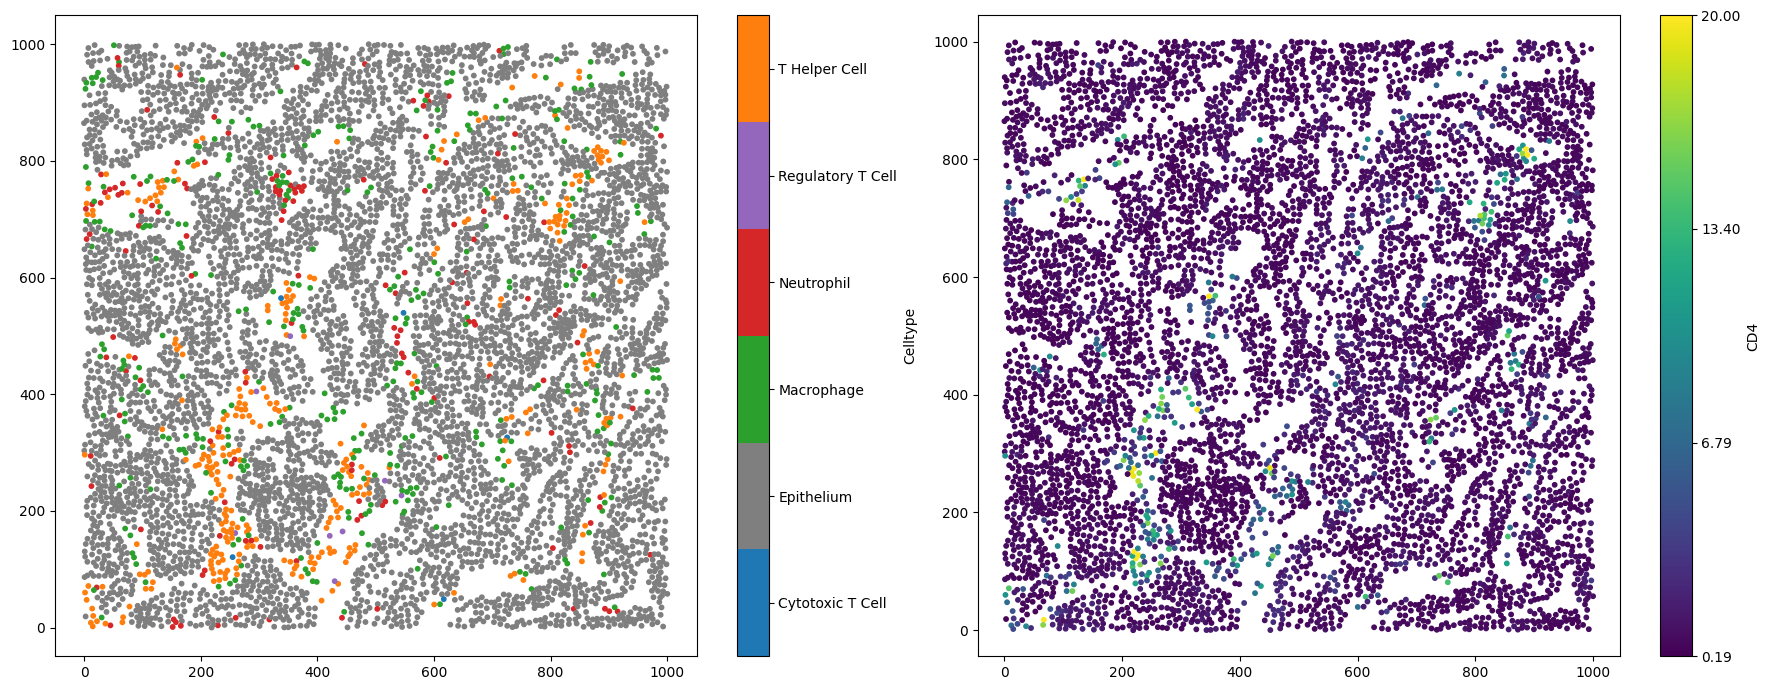

In [1]:
import muspan as ms
import matplotlib.pyplot as plt 

# Load an example domain dataset
example_domain = ms.datasets.load_example_domain('Mouse-Colon-Carcinoma')

# Create a figure with 2 subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Visualise the example domain, colouring by 'Celltype' in the first subplot
ms.visualise.visualise(example_domain, color_by='Celltype', ax=ax[0], marker_size=10)

# Visualise the example domain, colouring by 'CD4' in the second subplot
ms.visualise.visualise(example_domain, color_by='CD4', ax=ax[1], vmax=20, marker_size=10)

**Generating some lattice-like data**

This dataset is composed of point-like data; however, hotspot analysis is typically conducted on lattice- or grid-like data (think states on a map of the US). More recently, hotspot analysis has emerged as a useful tool in cancer research for analysing regional transcriptomics datasets such as those produced using Visium HD. In fact, spatial autocorrelations can be computed on any type of spatial data - not just grid-like data! We'll see this later in this tutorial.

To get us started with a more familiar data for hotspot analysis, we'll generate a lattice in a domain using the ``generate_hexgrid`` in the ``region_based`` MuSpAn submodule.

In [2]:
# Generate a hexagonal grid over the example domain
# - side_length: length of the side of each hexagon
# - regions_collection_name: name of the collection of hexagonal regions
ms.region_based.generate_hexgrid(example_domain, side_length=50, regions_collection_name='Hexgrids 50')

Note when generating grids we count the number of the labels (for all labels by default) and is specified using the 'region counts: ...' identifier. Let's make sure these labels have been added to our domain by printing it.

In [3]:
print(example_domain)

Domain name: Mouse cells
Number of objects: 6851
Collections: ['Cell centres', 'Hexgrids 50']
Labels: ['Celltype', 'CD4', 'ROI', 'region counts: Cytotoxic T Cell', 'region counts: Epithelium', 'region counts: Macrophage', 'region counts: Neutrophil', 'region counts: Regulatory T Cell', 'region counts: T Helper Cell', 'region counts: CD4'] 
Networks: [] 
Distance matrices: []


Great, we can see that we have generated a new collection of objects 'Hexgrids 50' and that each prior label category has now a 'regions counts: ...' associated with it. Let's visualise the counts of the T-Helper cell population on our lattice.

(<Figure size 1300x600 with 3 Axes>, <Axes: >)

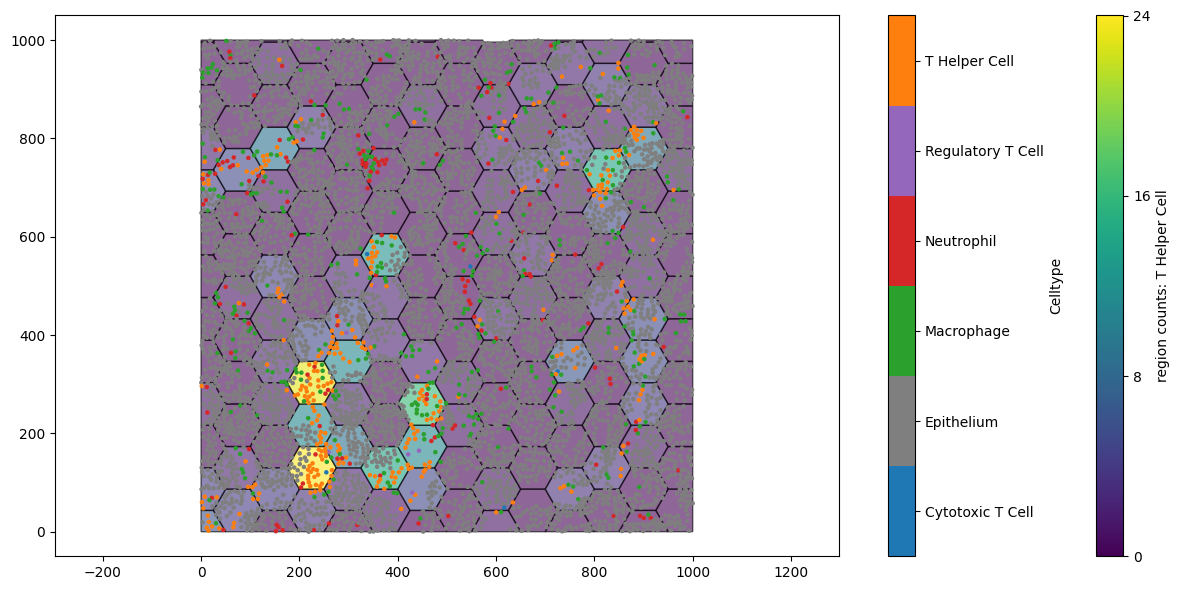

In [4]:
fig,ax=plt.subplots(figsize=(13,6))
ms.visualise.visualise(example_domain,color_by='region counts: T Helper Cell',objects_to_plot=('collection','Hexgrids 50'),ax=ax)  # plot the tiles
ms.visualise.visualise(example_domain,color_by='Celltype',objects_to_plot=('collection','Cell centres'),ax=ax,marker_size=5)  # plot the points

The regions with the most orange points (T Helper cells) are indicated on the lattice. This is similar to what we might see with transcriptional expression in a Visium HD sample. But it now leaves us with an interesting question: are these expression levels found near each other? Is this statistically significant with respect to spatial randomness?

**Using Moran's I**

To answer these questions, we can first employ the Moran's I statistic (shocking). The `morans_i` function can be found in the `spatial_statistics` module of MuSpAn. `morans_i` has two main parameters that determine the measurements:

1. `label_name`: the label name of the continuous data in the domain.

2. `network_kwargs`: connectivity of each object is defined by a network. We can control how this network is defined through the `network_kwargs` which uses the `generate_network` function. For more information, see our documentation on `generate_network`.

For lattice-like spatial data like we have above, we may want to define connectivity as the direct adjacent neighbours, i.e, any region that is touching another. We can construct this type of connectivity by using a 'proximity network' with a very small max_edge_distance. **Note:** We can examine the spatial clustering of the labels at different length scales by varying the 'max_edge_distance' and 'max_edge_distance' in our connectivity networks.

In MuSpAn, the Moran's I function produces both the global and local statistics (given as zscores) and the associated p-values with these zscores. In addition, object indices are also given ordered by the local Moran's I.

Phew... That's a lot of information. Not to worry - it's not as complicated as it might seem. To show this, we'll compute the Moran's I statistic on our generated lattice data using the number of T Hepler cell observations.


In [5]:
# Calculate Moran's I spatial autocorrelation statistics for the example domain
# - population: specifies the collection of objects to analyse ('Hexgrids 50')
# - label_name: the label to use for the analysis ('region counts: T Helper Cell')
# - alpha: significance level for the statistical test
# - network_kwargs: parameters for constructing the spatial network (Proximity network with min and max edge distances - set to max 1µm)
# - add_local_value_as_label: whether to add the local Moran's I values as labels to the objects
# - local_morans_label_name: name for the local Moran's I label to be added to the domain 

global_morans_i_zscore, global_morans_i_pval, local_morans_i_zscore, local_morans_i_pval, object_indices = ms.spatial_statistics.morans_i(
    example_domain,
    population=('Collection', 'Hexgrids 50'),
    label_name='region counts: T Helper Cell',
    alpha=0.05,
    network_kwargs={'network_type': 'Proximity', 'min_edge_distance': 0, 'max_edge_distance': 1},
    add_local_value_as_label=True,
    local_morans_label_name="Local Moran's I"
)

As mentioned above, there are several outputs that come with computing Moran's I. Let's start with unpacking our global statistics.

In [6]:
print("The global Moran's I zscore = ",global_morans_i_zscore,'(p-val = ',global_morans_i_pval,')')

The global Moran's I zscore =  5.965071168167877 (p-val =  2.445274389623247e-09 )


A Moran's I zscore >0 suggests that our counts of T Helper Cells in the regions are similar in similar regions when compared to a null of complete spatial randomness. This indicates the existence of clustering of our T-Helper Cells in our domain. In addition, a very low p-value supports the statistical significance of this obervation. These results can tell us about the existance of spatial clustering within our domain but we do not know exactly where this clustering is taking place. For this we need to check our local Moran's I values.

The local Moran's I provides a value to each object indicating the similarity of the labels that spatially connected to that object. MuSpAn provides these values as an output 'local_morans_i_zscore' with their p-val 'local_morans_i_pval', but these are also automatically added as labels to the objects. These labels are specified using the `local_morans_label_name` parameter in the `morans_i` function. Using this label name, MuSpAn adds labels for the Local Moran's I values, the p-values, and the Local Moran's I values filtered by p-value significance (controlled by the significance parameters `alpha`). Let's just check these have been added.

In [7]:
print(example_domain)

Domain name: Mouse cells
Number of objects: 6851
Collections: ['Cell centres', 'Hexgrids 50']
Labels: ['Celltype', 'CD4', 'ROI', 'region counts: Cytotoxic T Cell', 'region counts: Epithelium', 'region counts: Macrophage', 'region counts: Neutrophil', 'region counts: Regulatory T Cell', 'region counts: T Helper Cell', 'region counts: CD4', "Local Moran's I", "Local Moran's I : significant", "Local Moran's I : p-values (adj)"] 
Networks: [] 
Distance matrices: []


We can see that this has added "Local Moran's I", "Local Moran's I : significant", "Local Moran's I : p-values (adj)" as labels. Let's visualise these on the objects.

(<Figure size 2000x1600 with 8 Axes>, <Axes: >)

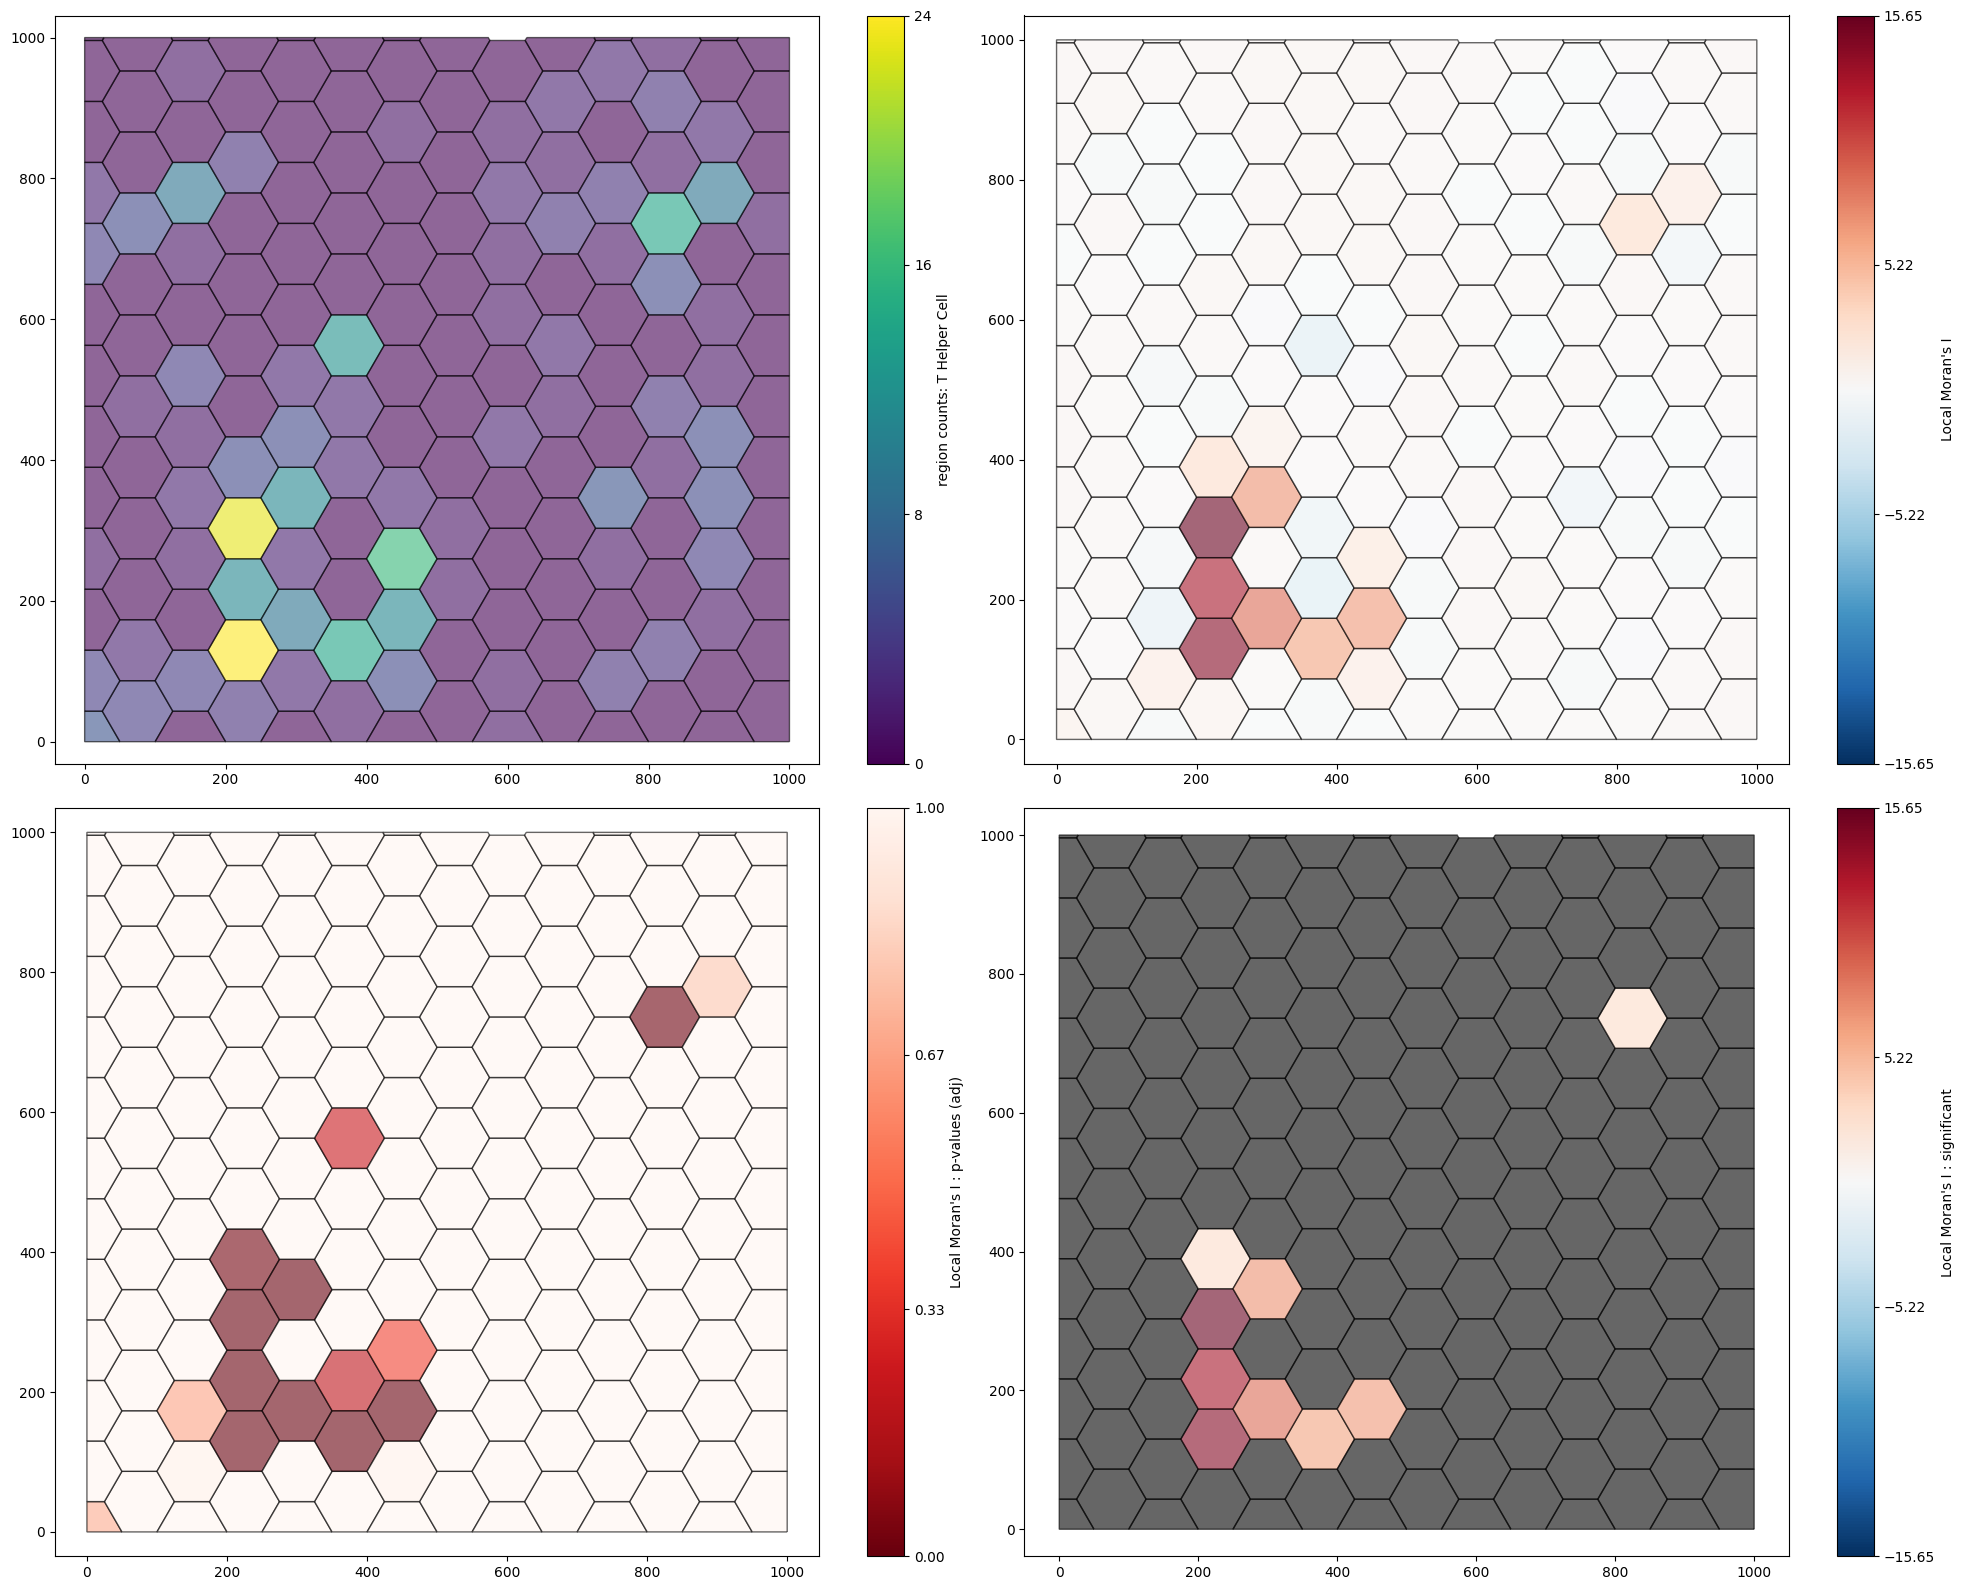

In [8]:
fig,ax=plt.subplots(figsize=(20,16),nrows=2,ncols=2)
ms.visualise.visualise(example_domain,color_by='region counts: T Helper Cell',objects_to_plot=('collection','Hexgrids 50'),ax=ax[0,0])
ms.visualise.visualise(example_domain,color_by="Local Moran's I",objects_to_plot=('collection','Hexgrids 50'),marker_size=5,ax=ax[0,1])
ms.visualise.visualise(example_domain,color_by="Local Moran's I : p-values (adj)",objects_to_plot=('collection','Hexgrids 50'),ax=ax[1,0])
ms.visualise.visualise(example_domain,color_by="Local Moran's I : significant",objects_to_plot=('collection','Hexgrids 50'),marker_size=5,ax=ax[1,1])

From this, we can see that there is a significant mass of T-helper cells surrounding a tumour nest.  

**Using Getis-Ord**

Instead, if we are more interested in the variations in local values of a continuous label, we could instead use the Getis Ord. The methodology of the Getis-Ord is very similar to Moran's I and therefore the parameters that define its functionality are identical. Again, our two main parameters are 1) `label_name` and 2) `network_kwargs`. We'll compute the local Getis-Ord statistic on the grid data using the `getis_ord` function in the `spatial_statistics` module, using identical parameters as above.

In [9]:
# Calculate Getis-Ord* spatial autocorrelation statistics for the example domain
# - population: specifies the collection of objects to analyse ('Hexgrids 50')
# - label_name: the label to use for the analysis ('region counts: T Helper Cell')
# - alpha: significance level for the statistical test
# - network_kwargs: parameters for constructing the spatial network (Proximity network with min and max edge distances)
# - add_local_value_as_label: whether to add the local Getis-Ord* values as labels to the objects
# - local_getis_label_name: name for the local Getis-Ord* label

local_getis_ord_zscore, local_getis_ord_pvals, object_indices = ms.spatial_statistics.getis_ord(
    example_domain,
    population=('Collection', 'Hexgrids 50'),
    label_name='region counts: T Helper Cell',
    alpha=0.05,
    network_kwargs={'network_type': 'Proximity', 'min_edge_distance': 0, 'max_edge_distance': 1},
    add_local_value_as_label=True,
    local_getis_label_name='Local Getis Ord'
)

As with the Moran's I, we are given the zscores and p-values associated with each object involved, but also the labels are automatically generated using the `local_getis_label_name` parameter.

In [10]:
print(example_domain)

Domain name: Mouse cells
Number of objects: 6851
Collections: ['Cell centres', 'Hexgrids 50']
Labels: ['Celltype', 'CD4', 'ROI', 'region counts: Cytotoxic T Cell', 'region counts: Epithelium', 'region counts: Macrophage', 'region counts: Neutrophil', 'region counts: Regulatory T Cell', 'region counts: T Helper Cell', 'region counts: CD4', "Local Moran's I", "Local Moran's I : significant", "Local Moran's I : p-values (adj)", 'Local Getis Ord', 'Local Getis Ord : significant', 'Local Getis Ord : p-values (adj)'] 
Networks: [] 
Distance matrices: []


We can see this has added the labels 'Local Getis Ord', 'Local Getis Ord : significant', 'Local Getis Ord : p-values (adj)'. We can visualise these as before.

(<Figure size 2000x1600 with 8 Axes>, <Axes: >)

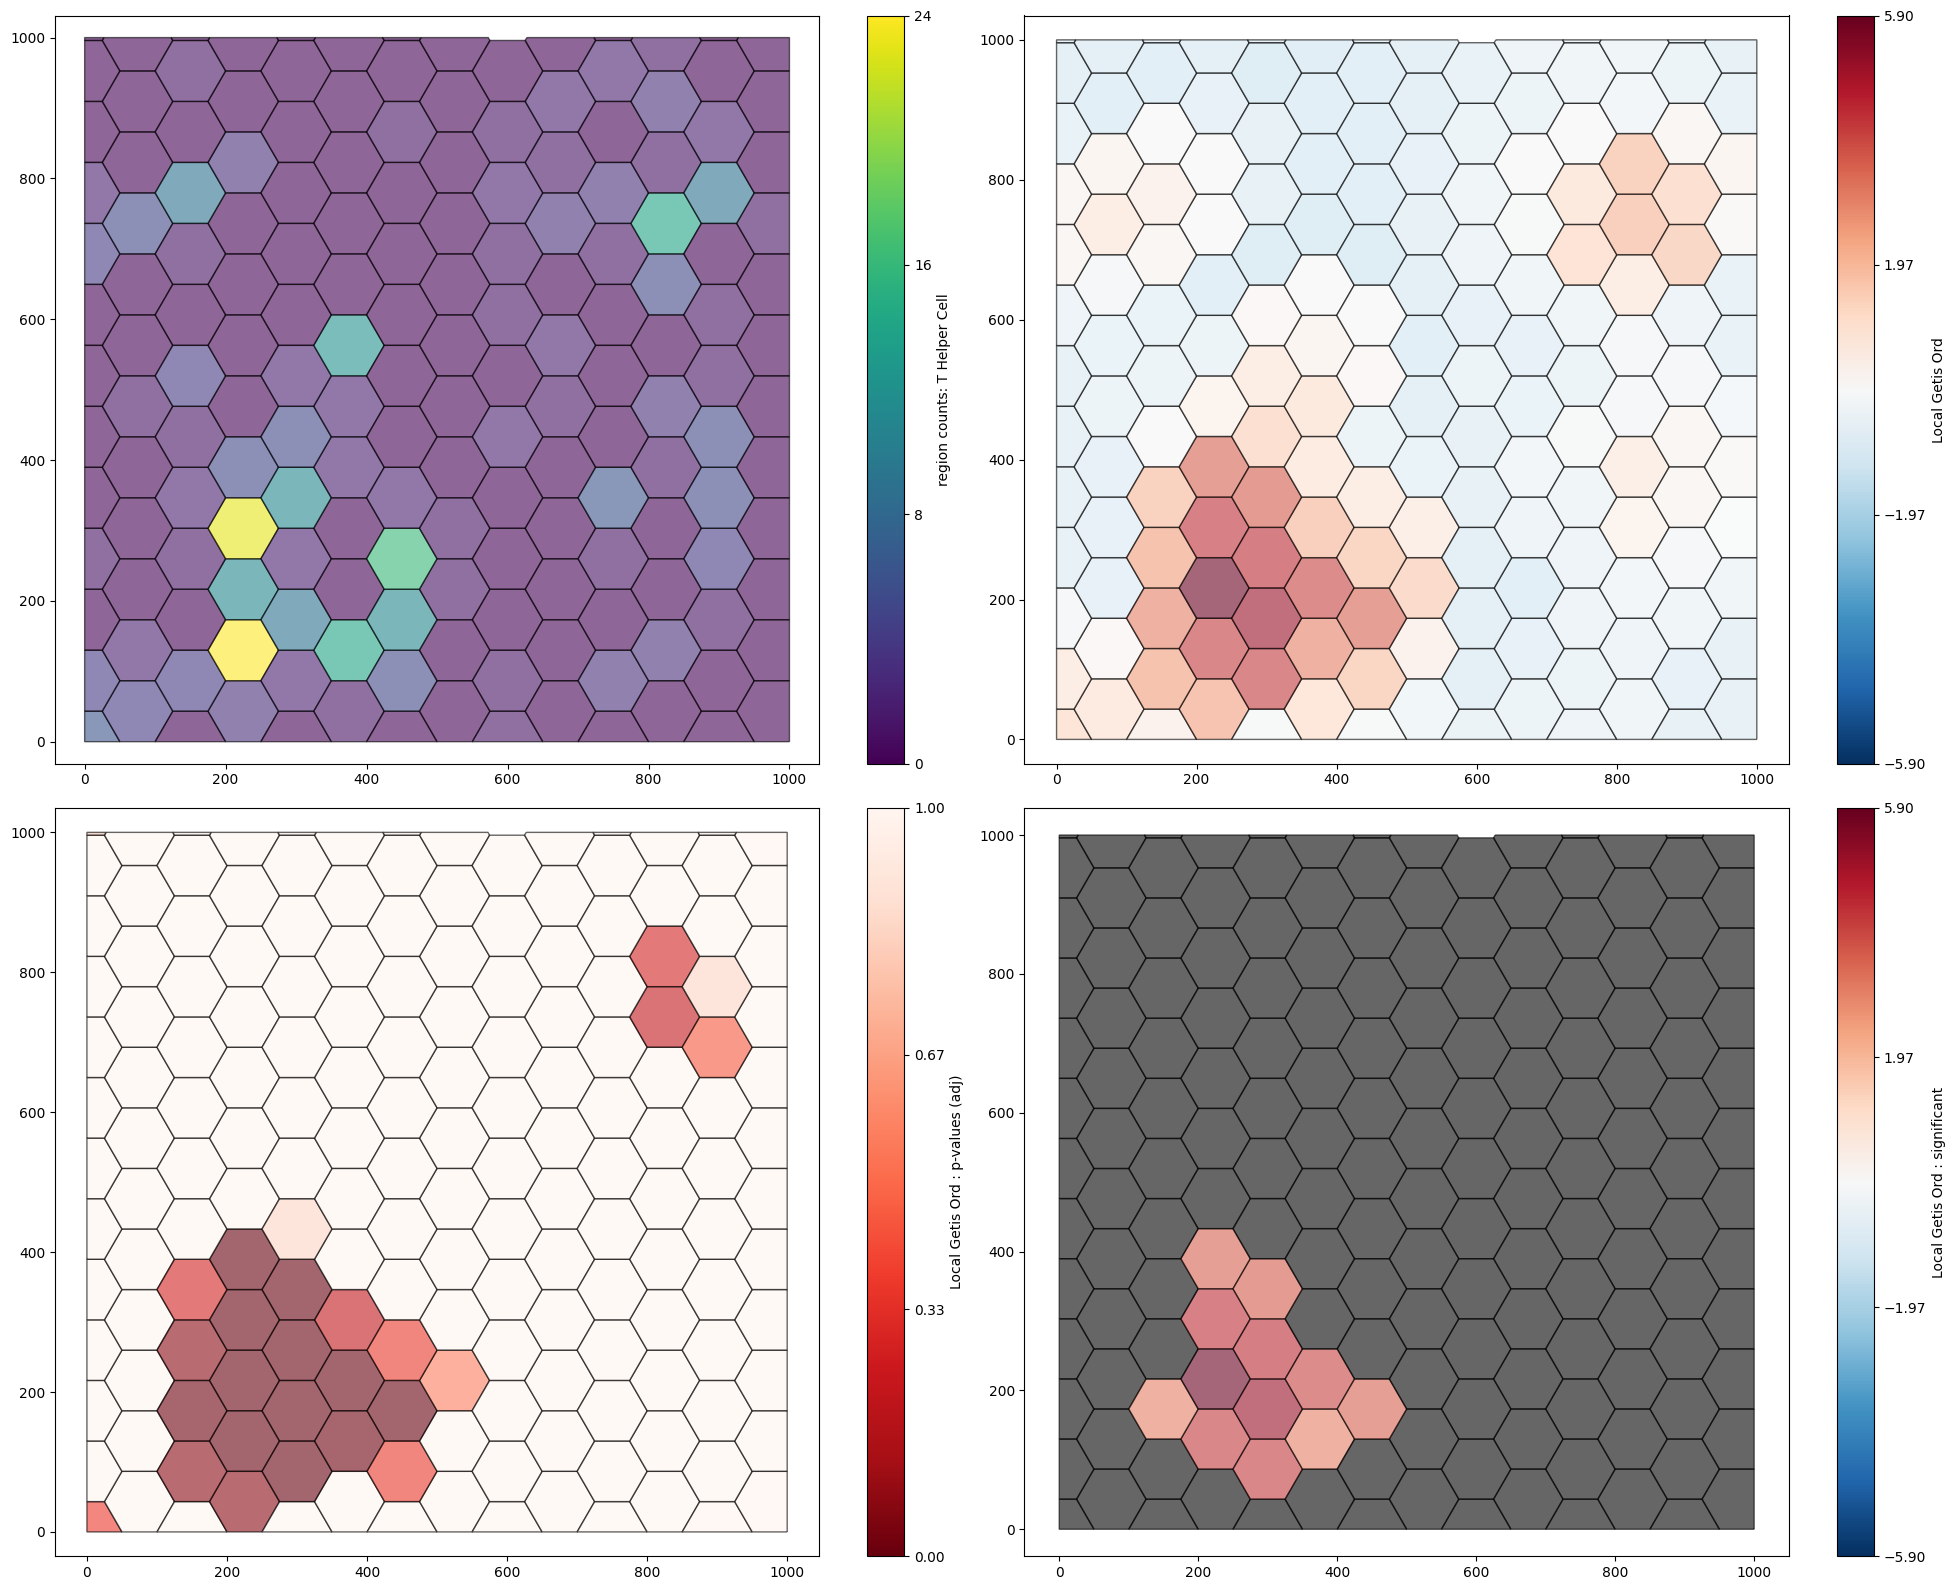

In [11]:
fig,ax=plt.subplots(figsize=(20,16),nrows=2,ncols=2)
ms.visualise.visualise(example_domain,color_by='region counts: T Helper Cell',objects_to_plot=('collection','Hexgrids 50'),ax=ax[0,0])
ms.visualise.visualise(example_domain,color_by="Local Getis Ord",objects_to_plot=('collection','Hexgrids 50'),marker_size=5,ax=ax[0,1])
ms.visualise.visualise(example_domain,color_by="Local Getis Ord : p-values (adj)",objects_to_plot=('collection','Hexgrids 50'),ax=ax[1,0])
ms.visualise.visualise(example_domain,color_by="Local Getis Ord : significant",objects_to_plot=('collection','Hexgrids 50'),marker_size=5,ax=ax[1,1])

In contrast to the local Moran's I values, the Getis-Ord* has identified a significant *hotspot* of T-Helper cell counts surrounding the tumour nest. In addition, we observe *cold* regions of counts in the space surrounding the tumour nest. This exemplifies the sensitivity of the Getis-Ord* to the magnitude of the continuous data on the objects, encouraging its use for local hotspot identification.

**Spatial autocorrelation on point-like data**

Spatial autocorrelations (like the Moran's I and Getis-Ord*) are not restricted to grid-like data but to any MuSpAn. Historically, these tools were used in field like Geography and Ecology where regions were usually defined by geographical maps and therefore, this is where we have most examples of their use. But their formal definitions allow for their application to any spatial data - all we have to do is define the spatial connectivity of the data and provided a continous label on these data.

Luckily, we have a dataset contain a point cloud with a continous marker for CD4. Let's compute both the Moran's I and Getis-Ord on these data.

The spatial connectivity of the data is defined by a network. We alter how we define the network using the `network_kwargs` parameter - which is sensible as we are no longer dealing with a lattice of shapes. Instead, we can represent the connectivity of the point through a 'Delaunay Triangulation' (see generating_networks tutorials), which will approximate local connectivity of the points.

In [12]:
global_morans_i_zscore_cells, global_morans_i_pval_cells, local_morans_i_zscore_cells, local_morans_i_pval_cells, object_indices_cells = ms.spatial_statistics.morans_i(example_domain,population=('Collection','Cell centres'),
                                                                                                                                                                        label_name='CD4', 
                                                                                                                                                                        alpha=0.05,
                                                                                                                                                                        network_kwargs={'network_type':'Delaunay','min_edge_distance':0,'max_edge_distance':30},
                                                                                                                                                                        add_local_value_as_label=True,
                                                                                                                                                                        local_morans_label_name="Local Moran's I (cells)")

print("The global Moran's I zscore = ",global_morans_i_zscore_cells,'(p-val = ',global_morans_i_pval_cells,')')

The global Moran's I zscore =  60.04758291352356 (p-val =  0.0 )


Once again, we can see that similar CD4 values are clustered in our domain from the global Moran's I statistic. In addition, we can compute the Getis-Ord* using the same parameters to identify hotspots of CD4 expression on our point cloud. 

**Note:** we will change the `local_getis_label_name` to not mix labels with our above analysis.

(<Figure size 2000x1600 with 8 Axes>, <Axes: >)

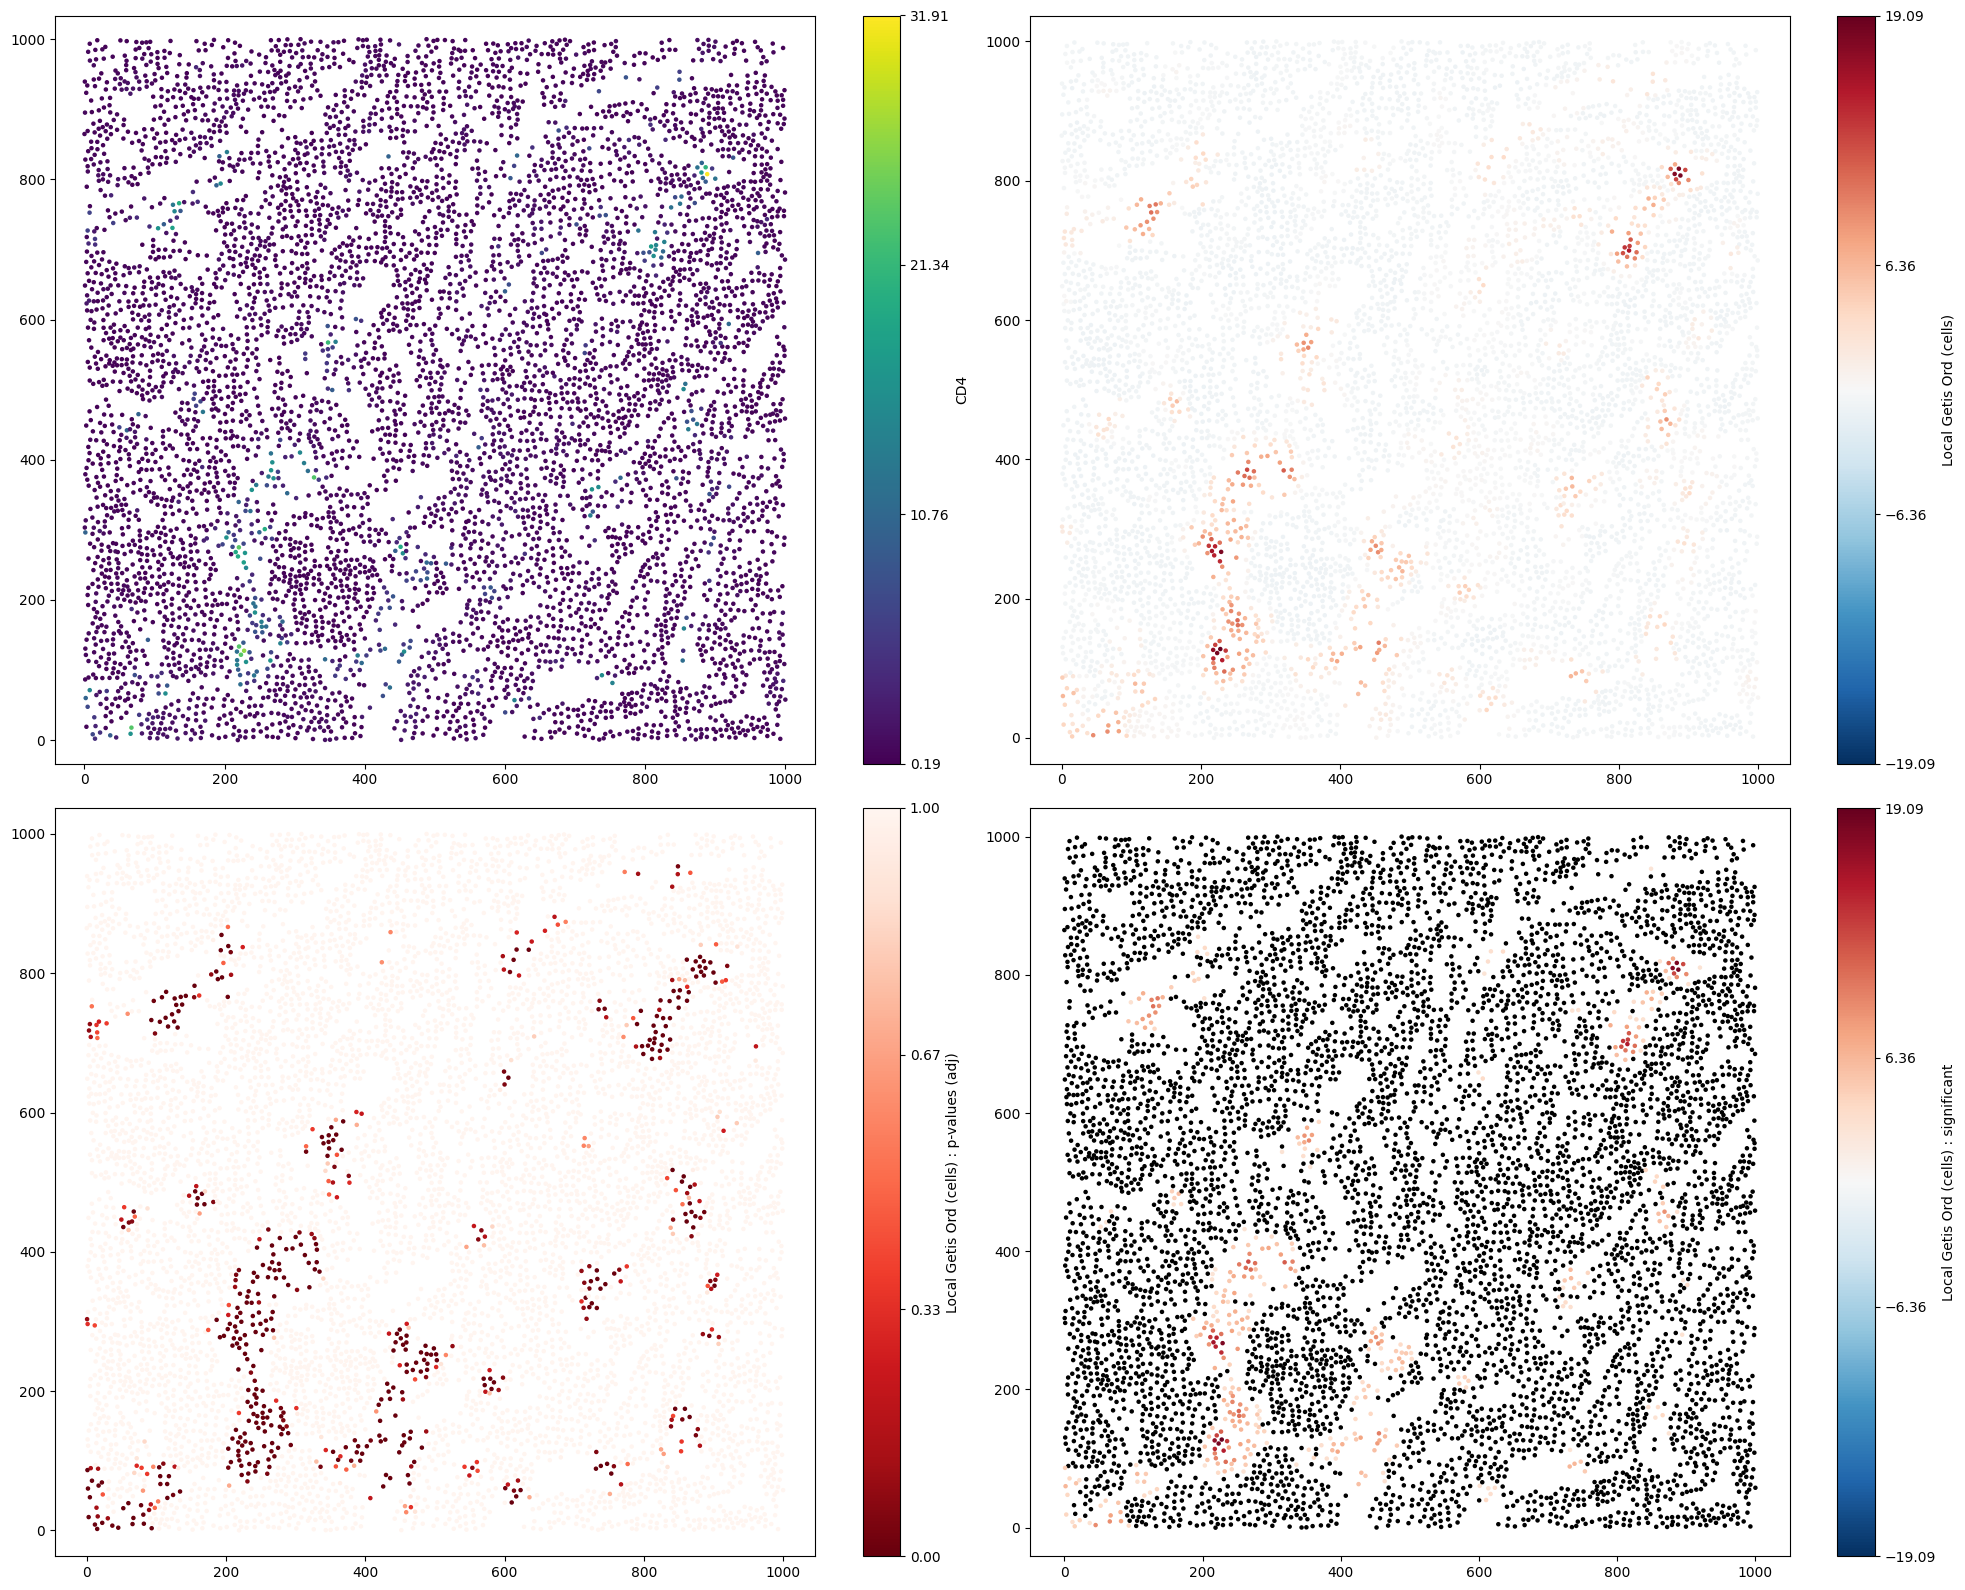

In [13]:
local_getis_ord_zscore, local_getis_ord_pvals, object_indices = ms.spatial_statistics.getis_ord(example_domain,population=('Collection','Cell centres'),
                                                                                                label_name='CD4', 
                                                                                                alpha=0.05,
                                                                                                network_kwargs={'network_type':'Delaunay','min_edge_distance':0,'max_edge_distance':30},
                                                                                                add_local_value_as_label=True,
                                                                                                local_getis_label_name='Local Getis Ord (cells)')


#visualise the Getis-Ord* statistics on the point objects
fig,ax=plt.subplots(figsize=(20,16),nrows=2,ncols=2)
ms.visualise.visualise(example_domain,color_by='CD4',objects_to_plot=('Collection','Cell centres'),marker_size=5,ax=ax[0,0])
ms.visualise.visualise(example_domain,color_by="Local Getis Ord (cells)",objects_to_plot=('Collection','Cell centres'),marker_size=5,ax=ax[0,1])
ms.visualise.visualise(example_domain,color_by="Local Getis Ord (cells) : p-values (adj)",objects_to_plot=('Collection','Cell centres'),marker_size=5,ax=ax[1,0])
ms.visualise.visualise(example_domain,color_by="Local Getis Ord (cells) : significant",objects_to_plot=('Collection','Cell centres'),marker_size=5,ax=ax[1,1])

**Conclusion**

In this tutorial, we explored the use of Moran's I and Getis-Ord* statistics to analyse spatial autocorrelation in tissue samples. We demonstrated how to compute these statistics on both shape-like and point-like data using the MuSpAn library. 

Key takeaways:

- **Moran's I** helps determine whether similar values are clustered together, dispersed, or randomly distributed. It provides both global and local measures of spatial autocorrelation.

- **Getis-Ord** identifies specific locations of statistically significant hotspots and coldspots, focusing on the magnitude of continuous data values.

By applying these methods, we can gain insights into the spatial patterns of gene or marker expression within tissue samples, which can be crucial for understanding tumor heterogeneity, the tumor microenvironment, and treatment resistance.

We hope this tutorial has provided you with a solid understanding of how to perform hotspot analysis using Moran's I and Getis-Ord* statistics with MuSpAn. For further details on the mathematical and statistical foundations of these methods, please refer to the recommended literature.